# 1. we gonna combine these datasets.. for getting the mid value.. not right not left right in the middle 

In [27]:
import os
import pandas as pd
#../../data/raw/multi_class_kaggle
# parent directory
BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed

# columns to average
COLUMNS = [
    "timestamp",
    "acc_x_dashboard",
    "acc_y_dashboard",
    "acc_z_dashboard",
    "gyro_x_dashboard",
    "gyro_y_dashboard",
    "gyro_z_dashboard",
    "latitude",
    "longitude",
    "speed"
]

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    # process only directories
    if not os.path.isdir(folder_path):
        continue

    left_path = os.path.join(folder_path, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(folder_path, "dataset_gps_mpu_right.csv")

    # skip if required files don't exist
    if not (os.path.exists(left_path) and os.path.exists(right_path)):
        print(f"Skipping {folder}: missing left/right CSV")
        continue

    # load datasets
    df_left = pd.read_csv(left_path)
    df_right = pd.read_csv(right_path)

    # ensure required columns exist
    missing_left = set(COLUMNS) - set(df_left.columns)
    missing_right = set(COLUMNS) - set(df_right.columns)

    if missing_left or missing_right:
        print(f"Skipping {folder}: missing columns")
        continue

    # row-wise average
    df_mid = (df_left[COLUMNS] + df_right[COLUMNS]) / 2

    # save result
    output_path = os.path.join(folder_path, "dataset_gps_mpu_mid.csv")
    df_mid.to_csv(output_path, index=False)

    print(f"Saved midpoint dataset for {folder}")


Saved midpoint dataset for PVS 1
Saved midpoint dataset for PVS 2
Saved midpoint dataset for PVS 3
Saved midpoint dataset for PVS 4
Saved midpoint dataset for PVS 5
Saved midpoint dataset for PVS 6
Saved midpoint dataset for PVS 7
Saved midpoint dataset for PVS 8
Saved midpoint dataset for PVS 9


## 2. re-naming columns for ease of view

In [28]:
import os
import pandas as pd

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed

# column rename mapping
RENAME_MAP = {
    "acc_x_dashboard": "ax",
    "acc_y_dashboard": "ay",
    "acc_z_dashboard": "az",
    "gyro_x_dashboard": "wx",
    "gyro_y_dashboard": "wy",
    "gyro_z_dashboard": "wz"
}

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    mid_path = os.path.join(folder_path, "dataset_gps_mpu_mid.csv")

    if not os.path.exists(mid_path):
        print(f"Skipping {folder}: midpoint file not found")
        continue

    df = pd.read_csv(mid_path)

    # rename columns (only those that exist)
    df.rename(columns=RENAME_MAP, inplace=True)

    # overwrite the same file
    df.to_csv(mid_path, index=False)

    print(f"Renamed columns in {folder}")


Renamed columns in PVS 1
Renamed columns in PVS 2
Renamed columns in PVS 3
Renamed columns in PVS 4
Renamed columns in PVS 5
Renamed columns in PVS 6
Renamed columns in PVS 7
Renamed columns in PVS 8
Renamed columns in PVS 9


## 3. deleted extra files

In [29]:
import os

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed

# files to keep
KEEP_FILES = {
    "dataset_gps_mpu_left.csv",
    "dataset_gps_mpu_mid.csv",
    "dataset_gps_mpu_right.csv",
    "video_environment_dataset_right.mp4",
    "map.html", 
    "dataset_labels.csv"
}

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        # delete only files, not folders
        if os.path.isfile(file_path) and file not in KEEP_FILES:
            os.remove(file_path)
            print(f"Deleted {file_path}")

    print(f"Cleaned folder: {folder}")


Cleaned folder: PVS 1
Cleaned folder: PVS 2
Cleaned folder: PVS 3
Cleaned folder: PVS 4
Cleaned folder: PVS 5
Cleaned folder: PVS 6
Cleaned folder: PVS 7
Cleaned folder: PVS 8
Cleaned folder: PVS 9


## 4. jugged the road quality based on the video and labels

In [30]:
import os
import pandas as pd
import numpy as np

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    labels_path = os.path.join(folder_path, "dataset_labels.csv")
    mid_path = os.path.join(folder_path, "dataset_gps_mpu_mid.csv")

    if not (os.path.exists(labels_path) and os.path.exists(mid_path)):
        print(f"Skipping {folder}: missing required files")
        continue

    labels_df = pd.read_csv(labels_path)
    mid_df = pd.read_csv(mid_path)

    # initialize with default value
    road_quality = np.full(len(labels_df), -1)

    # -------- Priority 3 (highest) --------
    mask_3 = (
        (
            (labels_df["cobblestone_road"] == 1) & (labels_df["no_speed_bump"] == 0)
        ) |
        (labels_df["dirt_road"] == 1)
    ) & (
        (labels_df["bad_road_left"] == 1) |
        (labels_df["bad_road_right"] == 1)
    )

    road_quality[mask_3] = 3

    # -------- Priority 2 --------
    mask_2 = (
        (labels_df["cobblestone_road"] == 1) &
        (
            (labels_df["bad_road_left"] == 1) |
            (labels_df["regular_road_left"] == 1) |
            (labels_df["bad_road_right"] == 1) |
            (labels_df["regular_road_right"] == 1)
        ) &
        (road_quality == -1)
    )

    road_quality[mask_2] = 2

    # -------- Priority 1 --------
    mask_1 = (
        (labels_df["paved_road"] == 1) &
        (labels_df["asphalt_road"] == 1) &
        (labels_df["no_speed_bump"] == 0) &
        (
            (labels_df["good_road_left"] == 1) |
            (labels_df["regular_road_left"] == 1) |
            (labels_df["good_road_right"] == 1) |
            (labels_df["regular_road_right"] == 1)
        ) &
        (road_quality == -1)
    )

    road_quality[mask_1] = 1

    # -------- Priority 0 (lowest) --------
    mask_0 = (
        (labels_df["paved_road"] == 1) &
        (labels_df["asphalt_road"] == 1) &
        (labels_df["good_road_left"] == 1) &
        (labels_df["good_road_right"] == 1) &
        (road_quality == -1)
    )

    road_quality[mask_0] = 0

    # attach to midpoint dataset
    mid_df["roadQuality"] = road_quality

    # save back
    mid_df.to_csv(mid_path, index=False)

    print(f"Processed roadQuality for {folder}")


Processed roadQuality for PVS 1
Processed roadQuality for PVS 2
Processed roadQuality for PVS 3
Processed roadQuality for PVS 4
Processed roadQuality for PVS 5
Processed roadQuality for PVS 6
Processed roadQuality for PVS 7
Processed roadQuality for PVS 8
Processed roadQuality for PVS 9


### 5. i see we getting -1 rows so inspecting what rows / logic did i miss

In [31]:
import os
import pandas as pd

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    labels_path = os.path.join(folder_path, "dataset_labels.csv")

    if not os.path.exists(labels_path):
        continue

    labels_df = pd.read_csv(labels_path)

    # ----- define condition masks -----

    mask_3 = (
        (
            (labels_df["cobblestone_road"] == 1) &
            (labels_df["no_speed_bump"] == 0) & 
            (
                (labels_df["bad_road_left"] == 1) |
                (labels_df["bad_road_right"] == 1)
            )
        ) |
        (labels_df["dirt_road"] == 1)
    ) 

    mask_2 = (
        (labels_df["cobblestone_road"] == 1) 
    )

    mask_1 = (
        (labels_df["paved_road"] == 1) &
        (labels_df["asphalt_road"] == 1)
    )

    mask_0 = (
        (labels_df["paved_road"] == 1) &
        (labels_df["asphalt_road"] == 1) &
        (labels_df["good_road_left"] == 1) &
        (labels_df["no_speed_bump"] == 1) &
        (labels_df["good_road_right"] == 1)
    )

    # ----- unmatched rows -----
    unmatched_mask = ~(mask_3 | mask_2 | mask_1 | mask_0)

    if not unmatched_mask.any():
        print(f"{folder}: no unmatched rows")
        continue

    # keep original index as a column
    unmatched_df = labels_df.loc[unmatched_mask].copy()
    unmatched_df.insert(0, "original_row_index", unmatched_df.index)

    # save
    output_path = os.path.join(folder_path, "unmatched_labels.csv")
    unmatched_df.to_csv(output_path, index=False)

    print(f"{folder}: saved {len(unmatched_df)} unmatched rows with indices")


PVS 1: no unmatched rows
PVS 2: no unmatched rows
PVS 3: no unmatched rows
PVS 4: no unmatched rows
PVS 5: no unmatched rows
PVS 6: no unmatched rows
PVS 7: no unmatched rows
PVS 8: no unmatched rows
PVS 9: no unmatched rows


### 6. did updates till there was no row unmatched

In [32]:
#cleaning code to remove previous iteration's unmached_lablel.csv
import os

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    unmatched_path = os.path.join(folder_path, "unmatched_labels.csv")

    if os.path.exists(unmatched_path):
        os.remove(unmatched_path)
        print(f"Deleted: {unmatched_path}")
    else:
        print(f"No unmatched file in: {folder}")



No unmatched file in: PVS 1
No unmatched file in: PVS 2
No unmatched file in: PVS 3
No unmatched file in: PVS 4
No unmatched file in: PVS 5
No unmatched file in: PVS 6
No unmatched file in: PVS 7
No unmatched file in: PVS 8
No unmatched file in: PVS 9


### 7. final label matching of dataset

In [33]:
import os
import pandas as pd
import numpy as np

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    labels_path = os.path.join(folder_path, "dataset_labels.csv")
    mid_path = os.path.join(folder_path, "dataset_gps_mpu_mid.csv")

    if not (os.path.exists(labels_path) and os.path.exists(mid_path)):
        print(f"Skipping {folder}: missing required files")
        continue

    labels_df = pd.read_csv(labels_path)
    mid_df = pd.read_csv(mid_path)

    # initialize with default unmatched value
    road_quality = np.full(len(labels_df), -1)

    # ---------- Priority 3 (highest) ----------
    mask_3 = (
        (
            (labels_df["cobblestone_road"] == 1) &
            (labels_df["no_speed_bump"] == 0) &
            (
                (labels_df["bad_road_left"] == 1) |
                (labels_df["bad_road_right"] == 1)
            )
        ) |
        (labels_df["dirt_road"] == 1)
    )

    road_quality[mask_3] = 3

    # ---------- Priority 2 ----------
    mask_2 = (
        (labels_df["cobblestone_road"] == 1) &
        (road_quality == -1)
    )

    road_quality[mask_2] = 2

    # ---------- Priority 0 ----------
    mask_0 = (
        (labels_df["paved_road"] == 1) &
        (labels_df["asphalt_road"] == 1) &
        (labels_df["good_road_left"] == 1) &
        (labels_df["good_road_right"] == 1) &
        (labels_df["no_speed_bump"] == 1) &
        (road_quality == -1)
    )

    road_quality[mask_0] = 0

    # ---------- Priority 1 (lowest) ----------
    mask_1 = (
        (labels_df["paved_road"] == 1) &
        (labels_df["asphalt_road"] == 1) &
        (road_quality == -1)
    )

    road_quality[mask_1] = 1

    # attach to midpoint dataset
    mid_df["roadQuality"] = road_quality
    

    # save back
    mid_df.to_csv(mid_path, index=False)

    print(f"{folder}: roadQuality assigned")


PVS 1: roadQuality assigned
PVS 2: roadQuality assigned
PVS 3: roadQuality assigned
PVS 4: roadQuality assigned
PVS 5: roadQuality assigned
PVS 6: roadQuality assigned
PVS 7: roadQuality assigned
PVS 8: roadQuality assigned
PVS 9: roadQuality assigned


### 8. downsampling to match phone sensor sampling rate 

In [34]:
import os
import pandas as pd

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed
TARGET_DT = 0.1         # desired sampling interval (seconds)

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    mid_path = os.path.join(folder_path, "dataset_gps_mpu_mid.csv")

    if not os.path.exists(mid_path):
        print(f"Skipping {folder}: dataset_gps_mpu_mid.csv not found")
        continue

    df = pd.read_csv(mid_path)

    if "timestamp" not in df.columns:
        print(f"Skipping {folder}: no timestamp column")
        continue

    # ensure sorted by time
    df = df.sort_values("timestamp").reset_index(drop=True)

    # downsample based on time difference
    keep_indices = [0]
    last_time = df.loc[0, "timestamp"]

    for i in range(1, len(df)):
        current_time = df.loc[i, "timestamp"]
        if current_time - last_time >= TARGET_DT:
            keep_indices.append(i)
            last_time = current_time

    df_downsampled = df.loc[keep_indices].reset_index(drop=True)

    # overwrite file
    df_downsampled.to_csv(mid_path, index=False)

    print(f"{folder}: downsampled {len(df)} → {len(df_downsampled)} rows")


PVS 1: downsampled 144036 → 13444 rows
PVS 2: downsampled 124684 → 11638 rows
PVS 3: downsampled 105816 → 9877 rows
PVS 4: downsampled 132492 → 12366 rows
PVS 5: downsampled 133877 → 12496 rows
PVS 6: downsampled 96279 → 8987 rows
PVS 7: downsampled 128548 → 11998 rows
PVS 8: downsampled 123618 → 11538 rows
PVS 9: downsampled 91555 → 8546 rows


### 9. combine all of them in one big dataset


In [35]:
import os
import pandas as pd

BASE_DIR = r"../../data/raw/multi_class_kaggle"   # change if needed
TARGET_FILE = "dataset_gps_mpu_mid.csv"

combined_df = []

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    file_path = os.path.join(folder_path, TARGET_FILE)

    if not os.path.exists(file_path):
        print(f"Skipping {folder}: file not found")
        continue

    df = pd.read_csv(file_path)

    # optional: keep track of source folder
    df["source_folder"] = folder

    combined_df.append(df)

if not combined_df:
    raise RuntimeError("No datasets found to combine")

# concatenate everything
final_df = pd.concat(combined_df, ignore_index=True)

# save in ../../data/combined/multi_class_kaggle.csv
output_path = "../../data/combined/multi_class_kaggle.csv"
final_df.to_csv(output_path, index=False)

print(f"Combined dataset saved as {output_path}")
print(f"Total rows: {len(final_df)}")


Combined dataset saved as ../../data/combined/multi_class_kaggle.csv
Total rows: 100890


### 10.matching the measuring units as per mobile phone

In [36]:
import pandas as pd
import numpy as np

# path to dataset
FILE_PATH = "../../data/combined/multi_class_kaggle.csv"

# load dataframe
df = pd.read_csv(FILE_PATH)

# ---- convert angular velocity: deg/s -> rad/s ----
DEG_TO_RAD = np.pi / 180.0

for col in ["wx", "wy", "wz"]:
    df[col] = df[col] * DEG_TO_RAD

# ---- save back (overwrite) ----
df.to_csv(FILE_PATH, index=False)


## 11. Plotting graph to visualise sensor readings on different roadQuality conditions

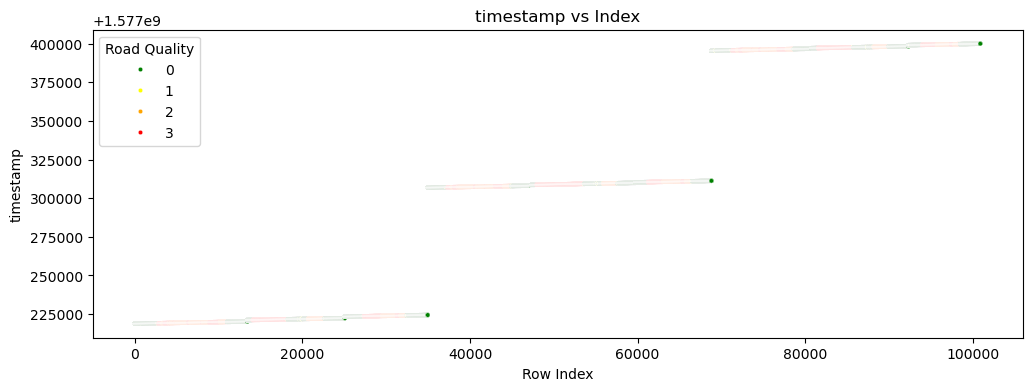

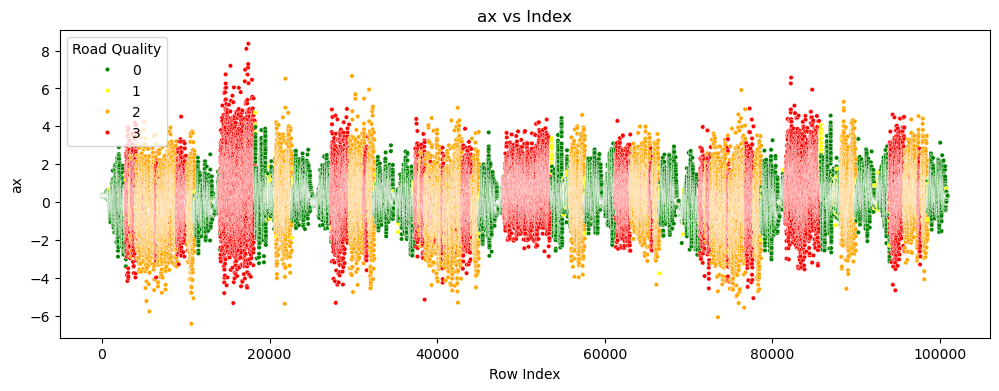

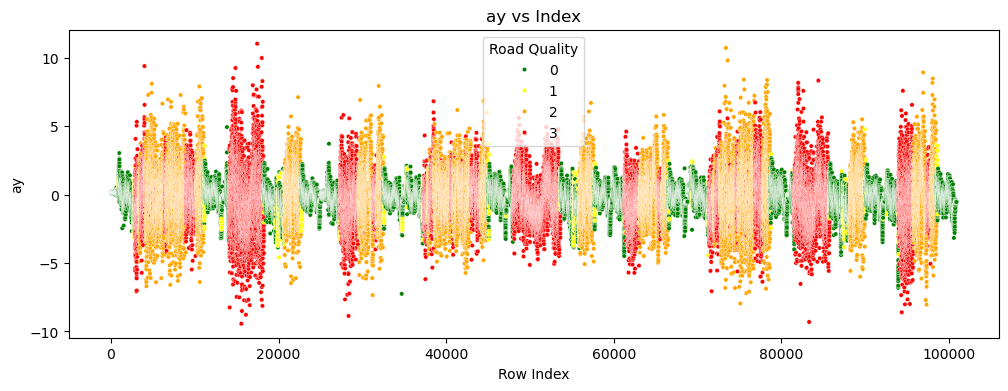

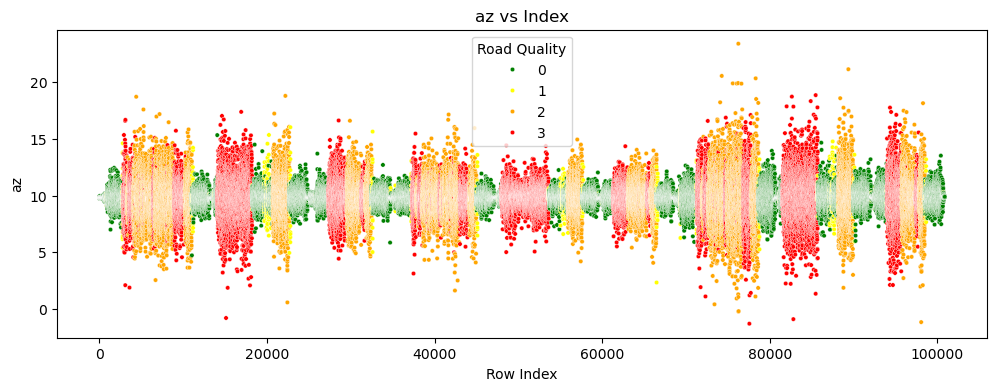

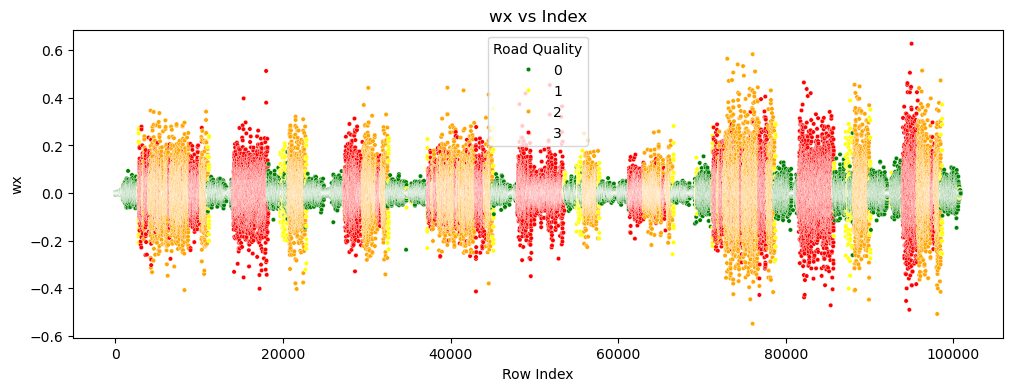

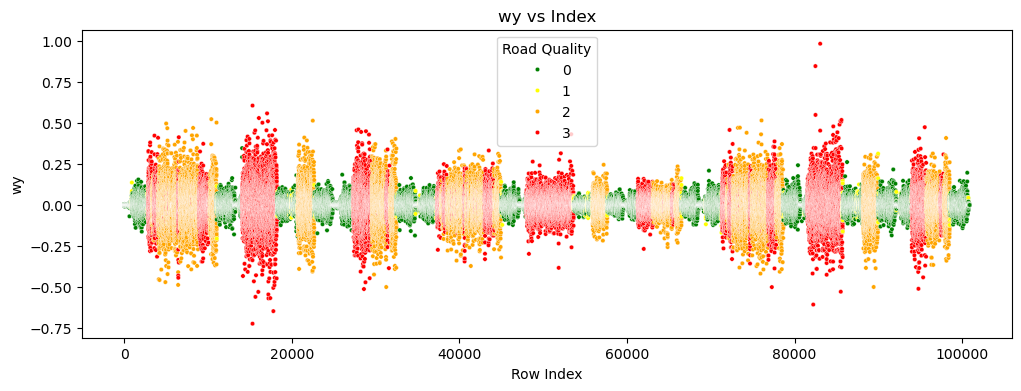

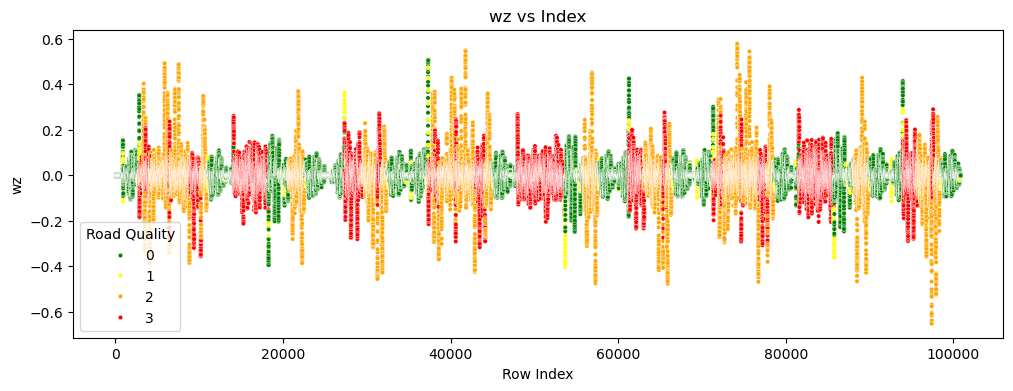

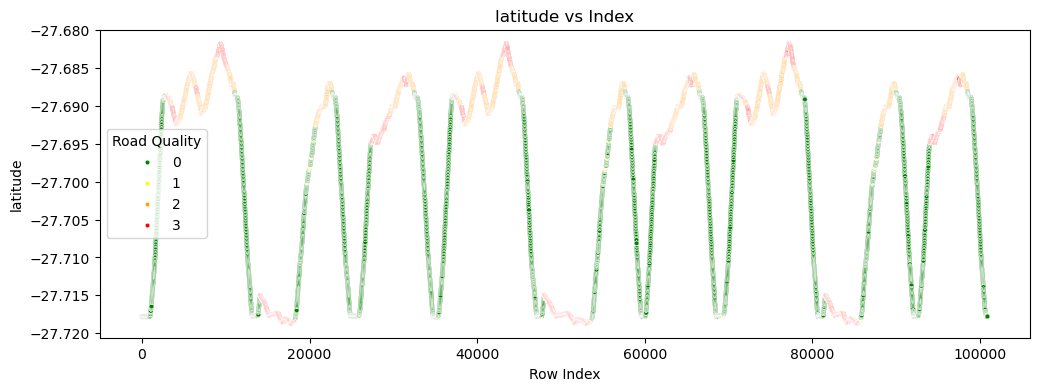

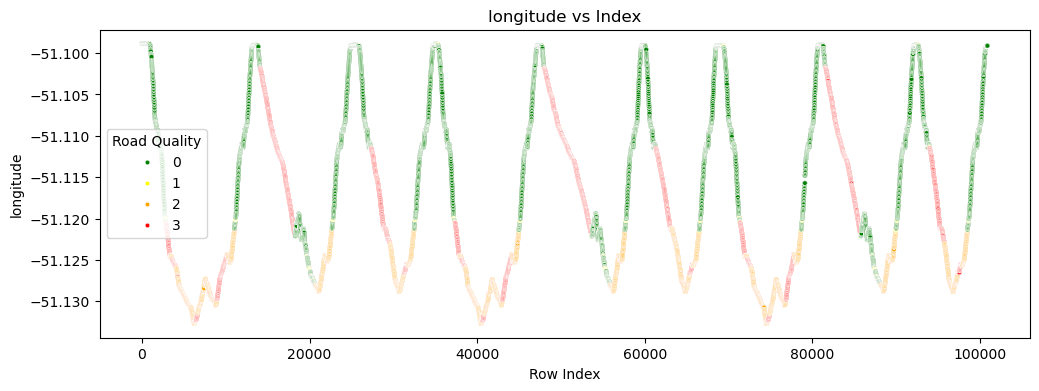

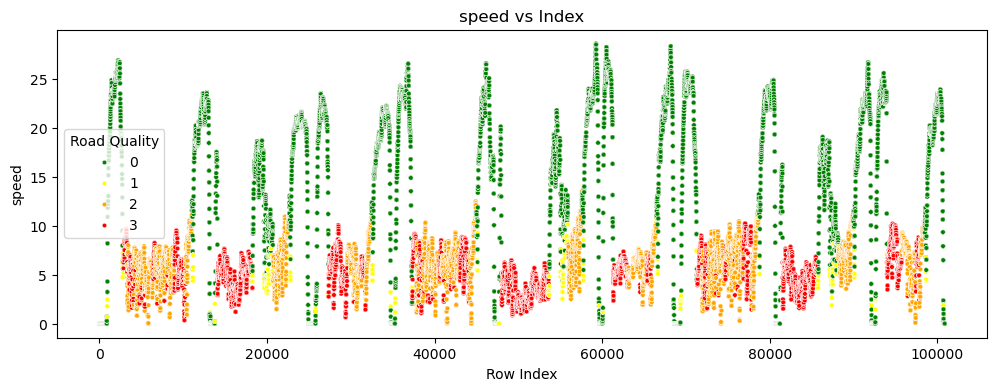

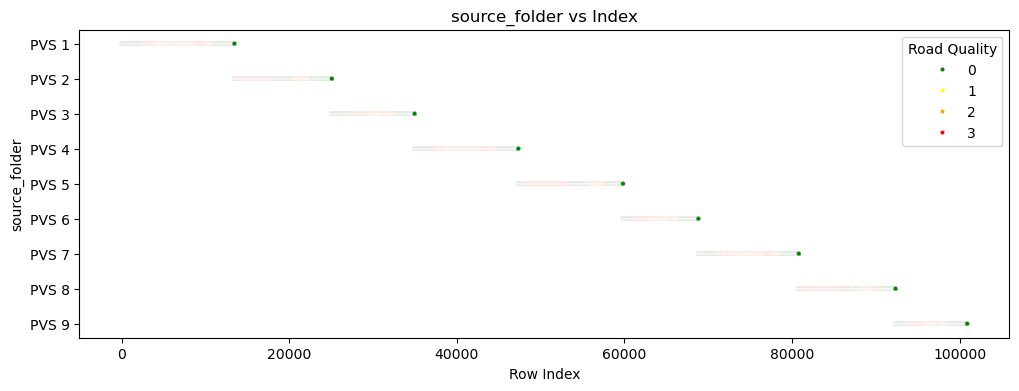

In [37]:
import pandas as pd
df = pd.read_csv("../../data/combined/multi_class_kaggle.csv")
import matplotlib.pyplot as plt
import seaborn as sns

features = df.columns.drop('roadQuality')
colors = {0: 'green', 1: 'yellow', 2: 'orange', 3: 'red'}

for feature in features:
    plt.figure(figsize=(12, 4))
    sns.scatterplot(x=df.index, y=df[feature], hue=df['roadQuality'], palette=colors, s=10)
    plt.title(f'{feature} vs Index')
    plt.xlabel('Row Index')
    plt.ylabel(feature)
    plt.legend(title='Road Quality')
    plt.show()